# Set-up


In [53]:
import os
import numpy as np
import scipy
import scipy.io
import scipy.stats as stats
from PIL import Image
import pywt
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [54]:
!python --version
print(scipy.version.version)

Python 3.8.5
1.5.2


# Functions

In [55]:
def get_data_from_Drive(path_to_data_folder):
  from google.colab import drive
  drive.mount('/content/drive')
  return get_data_from_folder(os.path.join("/content/drive/MyDrive", path_to_data_folder))  

def get_data_from_folder( path_to_data_folder ):
  #Each class must recide in its own folder.
  #Returns data as (image as nparray, class)
  #gathering classes
  class_titles = os.listdir(path_to_data_folder)
  classes_list = list( ( enumerate( class_titles ) ) )
  ordered_image_names = []
  #placing image, class identifier (from classes_list) pairs in a list named data
  data = []
  number_of_images = 0
  errors = 0 
  for gyro_class in classes_list:
    for image_name in os.listdir( os.path.join( path_to_data_folder, gyro_class[1] ) ):
      number_of_images+=1
      try:
        im = Image.open( os.path.join( path_to_data_folder, gyro_class[1] , image_name)  )
        color_image_nparray = np.asarray( im )
        data.append( [color_image_nparray, gyro_class[0]] )
        ordered_image_names.append(image_name)
      except Exception as error :
        errors+=1
        print( error, image_name)

  return data, class_titles, ordered_image_names, ( number_of_images, errors )

def get_coefficients_flattend( image, wavelet, levels ):
  #image as nparray with color
  #flattens and groups coefficients by orientation and subband
  #returns as  ( cAn, (cHn, cVn, cDn), … (cH1, cV1, cD1)  )
  #                                 . 
  #                                 .     
  #                                 . 
  #for each picture
  #n is the level of decomposition
  
  pil_image = Image.fromarray(image, "RGB")
  pil_gray_image = pil_image.convert("L")
  gray_img = np.asarray( pil_gray_image ) 
  decomposed = pywt.wavedec2( gray_img , wavelet, level=levels)

  coeff=[]
  for subband in range(levels+1):
    if subband==0:
      coeff.append(np.asarray(decomposed[subband]).flatten())
      continue
    orientations=[]
    for orientation in decomposed[subband]:
      orientations.append( np.asarray(orientation).flatten() )
    coeff.append(orientations)    

  return coeff

def qqplots_of_image(image, wavelet, levels, dist):
  
  coeffs=get_coefficients_flattend(image, wavelet, levels)
  alpha=0.2

  fig,axes = plt.subplots(levels+1,3,figsize=(20,20), constrained_layout=True)
  
  #Progress
  print(getattr(dist,"name"), end=": ")
  for m in range(levels+1):
    if m==0:
      sm.qqplot(coeffs[0], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", markerfacecolor="black", mew=0, ax=axes[levels-m][0])
      axes[levels-m][0].set_title("Approximation")
      axes[levels-m][0].tick_params(direction="in")
      axes[levels-m][1].remove()
      axes[levels-m][2].remove()
      continue
    for i in range(3):
      if i==0: title="Level "+str(levels-m+1)+": Horizontal"
      if i==1: title="Level "+str(levels-m+1)+": Vertical"
      if i==2: title="Level "+str(levels-m+1)+": Diagonal"

      sm.qqplot(coeffs[m][i], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", markerfacecolor="black", mew=0, ax=axes[levels-m][i])
      axes[levels-m][i].set_title(title)
      axes[levels-m][i].tick_params(direction="in")

      #Progress
      print(levels-m+1,i,sep="", end=" ")
  print("")
  
  title="qqplots wavelet={} levels={} dist={}".format(wavelet, levels, getattr(dist,"name"))
  fig.suptitle(title, fontsize=16)
  fig.savefig(title)

  return



# Visualising grouping by distribution parameters

In [60]:
def data_to_coeffs(data, wavelet, levels):
    toReturn=[]
    for image, class_id in data:
        instance = get_coefficients_flattend(image, wavelet, levels), class_id
        toReturn.append(instance)
    return toReturn
#return 2D-array (coeffs, class)

def save_coeffs_for_matlab(data, wavelet, levels):
    all_coeffs = data_to_coeffs(data, wavelet, levels)
    toSave ={"wavelet":wavelet,\
             "levels":levels,\
             "coeffs":np.array(all_coeffs) }

    scipy.io.savemat("coefficients wt="+wavelet+"levels="+str(levels)+".mat", toSave)
    return

def load_distribution_parameters_from_matlab(distribution_parameters_path):
    load_dict = scipy.io.loadmat(distribution_parameters_path)

    return load_dict

def prepare_features_for_scikit(dist_params_select_path):
#path: to dist_paramsSelect    
    load_dict= load_distribution_parameters_from_matlab(dist_params_select_path)
    
    dist_params =load_dict["dist_params"]
    levels=load_dict["levels"].reshape(-1)[0]
    selection = load_dict["selection"]
    print(selection)
    features=[]
    labels=[]
    for instance_index in range(dist_params.shape[0]):
        features_from_instance=[]

        for level_index in range(dist_params[instance_index,0].shape[1]):
            a=level_index==0
            b=([0, 0] in selection.tolist())

            if a&b:
                param1 = dist_params[instance_index,0][0,0][0,0]
                param2 = dist_params[instance_index,0][0,0][0,1]
                features_from_instance.append(param1)
                features_from_instance.append(param2)
                print("instance:",instance_index, " Aprox")
                continue

            for orientation in range(3):
                if [levels-level_index+1, orientation+1] in selection.tolist():
                    param1 = dist_params[instance_index,0][0,level_index][orientation,0]
                    param2 = dist_params[instance_index,0][0,level_index][orientation,1]
                    features_from_instance.append(param1)
                    features_from_instance.append(param2)
                    print("instance:",instance_index," level:", levels-level_index+1, " orientation:",  orientation+1)
        features.append(features_from_instance)
        labels.append(dist_params[instance_index,1].reshape(-1)[0])
        
        
    return features, labels



def class_plot_from_distribution_parameters(distribution_parameters_path, save_folder_path):
#dist_params from matlab    
    _ , class_titles, _, _= get_data_from_folder("Data")
    load_dict = load_distribution_parameters_from_matlab(distribution_parameters_path)
    dist_params = load_dict["dist_params"]
    levels = load_dict["levels"][0][0]
    wavelet = load_dict["wavelet"][0]
    distribution = load_dict["distribution"][0]
    fig, ax = plt.subplots(figsize=(10,10))
    title="Plot of distribution parameters for\nWavelet "+wavelet+" | Levels: "+str(levels)+" | Distribution: "+ distribution
    
    N=len(class_titles)
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0,N,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    for instance, label in dist_params:
        for level in np.reshape(instance, -1):
            for orientation in level:
                scat = ax.scatter(orientation[0], orientation[1], c=np.reshape(label,-1)[0], s=50, alpha=1, cmap=cmap, norm=norm)
    ax.set_title(title)
    
    ax.set_xlabel("Ditribution Parameter 1")
    ax.set_ylabel("Ditribution Parameter 2")
    ax.tick_params(direction="in")
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label("Classes")
    
    fig.savefig(os.path.join(save_folder_path, "wt= "+wavelet+" levels= "+str(levels)+" dist="+load_dict["distribution"][0]+".jpeg"), dpi=200)
    
    return

# Testing - Using

In [7]:
data , class_titles, ordered_image_names, results= get_data_from_folder("Data")
print("RESULTS\n",results,"\n==========================")
print("CLASS,titles\n",class_titles,"\n===========================")


cannot identify image file 'Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_1_bak.tif' Cichorium Intybus (Asteraceae)_1_bak.tif
cannot identify image file 'Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_3_bak.tif' Cichorium Intybus (Asteraceae)_3_bak.tif
cannot identify image file 'Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_bak.tif' Cichorium Intybus (Asteraceae)_bak.tif
RESULTS
 (56, 3) 
CLASS,titles
 ['castanea 2_pio synithismeni morfi', 'castanea sp', 'cichorium intubus pollen x 400', 'citrus sp', 'eukalyptus sp', 'hedera helix', 'helianthus', 'heliotropium', 'hibiscous', 'inula spinoza', 'origanum', 'pinus', 'sonchus', 'thymus sp pollen 20-01-21', 'tribulus sp'] 


In [ ]:
#wavevelet_decomposition, producing coefficients
wavelets = ["db4","db8","db12"]
levels_list = [5,6]
for wavelet in wavelets:
    for levels in levels_list:
        save_coeffs_for_matlab(data, wavelet, levels)
#now run matlab code

False


In [51]:
coeff_folder_path = "D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\coefficients\\"
dist_params_name="dist_paramsSelect wt=db4 levels=5 dist=Normal.mat"
X, Y = prepare_features_for_scikit("dist_paramsSelect wt=db4 levels=5 dist=Normal.mat")


[[5 1]
 [4 3]
 [4 2]
 [3 2]
 [0 0]]
instance: 0  Aprox
instance: 0  level: 5  orientation: 1
instance: 0  level: 4  orientation: 2
instance: 0  level: 4  orientation: 3
instance: 0  level: 3  orientation: 2
instance: 1  Aprox
instance: 1  level: 5  orientation: 1
instance: 1  level: 4  orientation: 2
instance: 1  level: 4  orientation: 3
instance: 1  level: 3  orientation: 2
instance: 2  Aprox
instance: 2  level: 5  orientation: 1
instance: 2  level: 4  orientation: 2
instance: 2  level: 4  orientation: 3
instance: 2  level: 3  orientation: 2
instance: 3  Aprox
instance: 3  level: 5  orientation: 1
instance: 3  level: 4  orientation: 2
instance: 3  level: 4  orientation: 3
instance: 3  level: 3  orientation: 2
instance: 4  Aprox
instance: 4  level: 5  orientation: 1
instance: 4  level: 4  orientation: 2
instance: 4  level: 4  orientation: 3
instance: 4  level: 3  orientation: 2
instance: 5  Aprox
instance: 5  level: 5  orientation: 1
instance: 5  level: 4  orientation: 2
instance: 5  l

In [ ]:
#now load matlab results
load_dict = scipy.io.loadmat("dist_params wt=db4 levels=5 dist=Normal.mat")
dist_params = load_dict["dist_params"]

In [ ]:
usable = dist_params
print(usable.shape)
toHist = []
def plot_fitted_params(parameters):
        continue

def hist_of_parameters(parameters):
  alpha=0.2

  fig,axes = plt.subplots(levels+1,3,figsize=(20,20), constrained_layout=True)
  
  #Progress
  print(getattr(dist,"name"), end=": ")
  for m in range(levels+1):
    if m==0:
      sm.qqplot(coeffs[0], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", mfc="black", mew=0, ax=axes[levels-m][0])
      axes[levels-m][0].set_title("Approximation")
      axes[levels-m][0].tick_params(direction="in")
      axes[levels-m][1].remove()
      axes[levels-m][2].remove()
      continue
    for i in range(3):
      if i==0: title="Level "+str(levels-m+1)+": Horizontal"
      if i==1: title="Level "+str(levels-m+1)+": Vertical"
      if i==2: title="Level "+str(levels-m+1)+": Diagonal"

      sm.qqplot(coeffs[m][i], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", mfc="black", mew=0, ax=axes[levels-m][i])
      axes[levels-m][i].set_title(title)
      axes[levels-m][i].tick_params(direction="in")

      #Progress
      print(levels-m+1,i,sep="", end=" ")
  print("")
  
  title="qqplots wavelet={} levels={} dist={}".format(wavelet, levels, getattr(dist,"name"))
  fig.suptitle(title, fontsize=16)
  fig.savefig(title)

  return

cannot identify image file 'Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_1_bak.tif' Cichorium Intybus (Asteraceae)_1_bak.tif
cannot identify image file 'Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_3_bak.tif' Cichorium Intybus (Asteraceae)_3_bak.tif
cannot identify image file 'Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_bak.tif' Cichorium Intybus (Asteraceae)_bak.tif


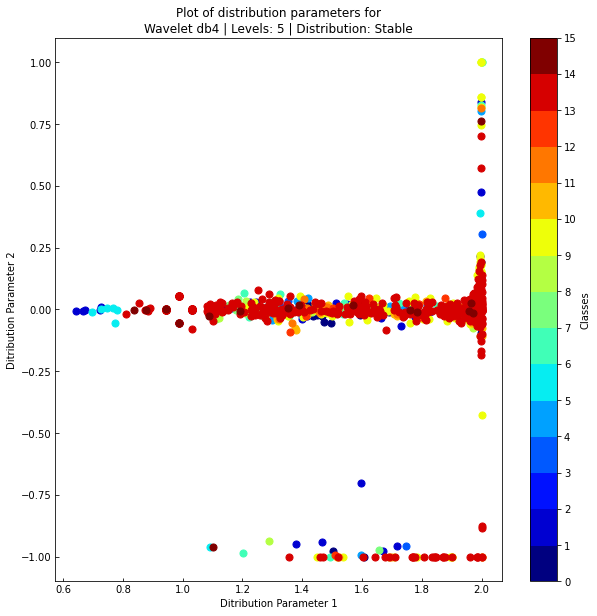

In [70]:
#single Class Plot
dist_params_folder_path = "D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\dist_params\\"
save_folder_path = "D:\\Work and uni\\University\\ML for food authentication\\Results_fitting\\Class Plots\\"

dist_params_name="dist_params wt=db4 levels=5 dist=Stable.mat"
dist_params_path=os.path.join(dist_params_folder_path, dist_params_name)
class_plot_from_distribution_parameters(dist_params_path, save_folder_path)

In [ ]:
#qqplots of image 2
print(ordered_image_names[7])
plt.imshow(data[7][0])
qqplots_of_image(data[2][0], "db12", 5, stats.norm)

# Visualisation of wavelet decomposition

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import statsmodels.api as sm
import scipy.stats as stats


n=3
im = Image.open("/content/drive/MyDrive/Copy of origanum_bak.tif")
plt.imshow(np.asarray(im))
plt

gray_img = im.convert("L")
plt.figure()
plt.imshow(np.asarray(gray_img), cmap=plt.get_cmap('gray'))
gray_array = np.asarray(gray_img)

C = pywt.wavedec2( gray_array , 'db1', level=n)

C[0] /= np.abs(C[0]).max()
for m in range(n):
  if m==0:
    continue
  for mat in C[m]:
    mat /= np.abs(mat).max()

arr , slices = pywt.coeffs_to_array(C)

plt.figure(figsize=[12,12])
plt.imshow(arr, cmap=plt.get_cmap('gray'), vmin=-0.25, vmax=0.75 )
plt.savefig("hooray.jpeg")

a=[1,2,['name', im]]
plt.figure()
plt.imshow(np.asarray(a[2][1]))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Copy of origanum_bak.tif'